In [1]:
%pip install clickhouse-driver matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import clickhouse_driver
import matplotlib.pyplot as plt
client = clickhouse_driver.Client(host='sol', port=9000, database='bts')

In [3]:
SCHEMA = '''
CREATE TABLE on_time_performance
(
    `FlightDate` Date,
    `Reporting_Airline` String,
    `DOT_ID_Reporting_Airline` UInt64,
    `Flight_Number_Reporting_Airline` UInt64,
    `Tail_Number` String,
    `Origin` String,
    `OriginStateName` String,
    `Dest` String,
    `DestStateName` String,
    `DepTime` String,
    `DepDelay` Float64,
    `TaxiOut` Float64,
    `WheelsOff` String,
    `WheelsOn` String,
    `TaxiIn` Float64,
    `CRSArrTime` String,
    `ArrTime` String,
    `ArrDelay` Float64,
    `AirTime` Float64,
    `Distance` Float64,
    `CRSElapsedTime` Float64,
    `ActualElapsedTime` Float64,
    `Cancelled` Float64,
    `Diverted` Float64,
    `CarrierDelay` Float64,
    `WeatherDelay` Float64,
    `NASDelay` Float64,
    `SecurityDelay` Float64,
    `LateAircraftDelay` Float64   
)
ENGINE = MergeTree
ORDER BY tuple(FlightDate, Reporting_Airline, Flight_Number_Reporting_Airline)
'''

In [4]:
from pprint import pprint

take = lambda data, index: [i[index] for i in data]
AIRLINES = {
    "AS": "Alaska",
    "HA": "Hawaiian",
    "DL": "Delta",
    "WN": "Southwest",
    "AA": "American",
    "UA": "United",
    "NK": "Spirit",
    "G4": "Allegiant",
    "F9": "Frontier",
    "B6": "JetBlue",
    "OO": "SkyWest",
    "MQ": "Envoy",
    "EV": "EVA",
    "YX": "Republic",
    "9E": "Endeavor",
    "OH": "PSA",
    "US": "US Airways",
    "VX": "Virgin America",
    "QX": "Horizon Air",
    "FL": "Florida",
    "CO": "Continental Airlines",
    "YV": "Mesa Airlines",
}

TOP_AIRLINES = [(i[0], AIRLINES.get(i[0], i[0])) for i in client.execute("SELECT Reporting_Airline, count(*) as count FROM on_time_performance GROUP BY Reporting_Airline ORDER BY count DESC")];
popular_airports = client.execute("SELECT Origin, count(*) as count FROM on_time_performance GROUP BY Origin ORDER BY count DESC");

row_count = client.execute("SELECT count(*) FROM on_time_performance")[0][0]
print(f"{row_count:,}")


157,274,758


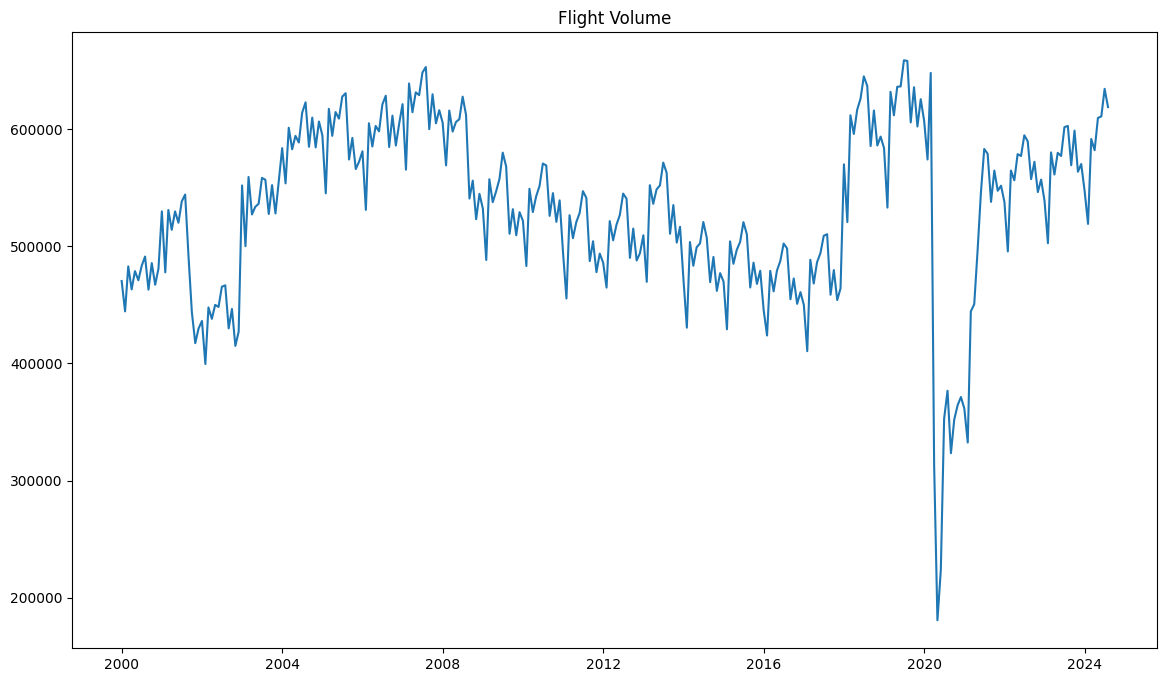

In [5]:
result = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, count(*) as count FROM on_time_performance GROUP BY when ORDER BY when");

plt.figure(figsize=(14, 8))
plt.plot(take(result, 0), take(result, 1))
plt.title("Flight Volume")
plt.show()

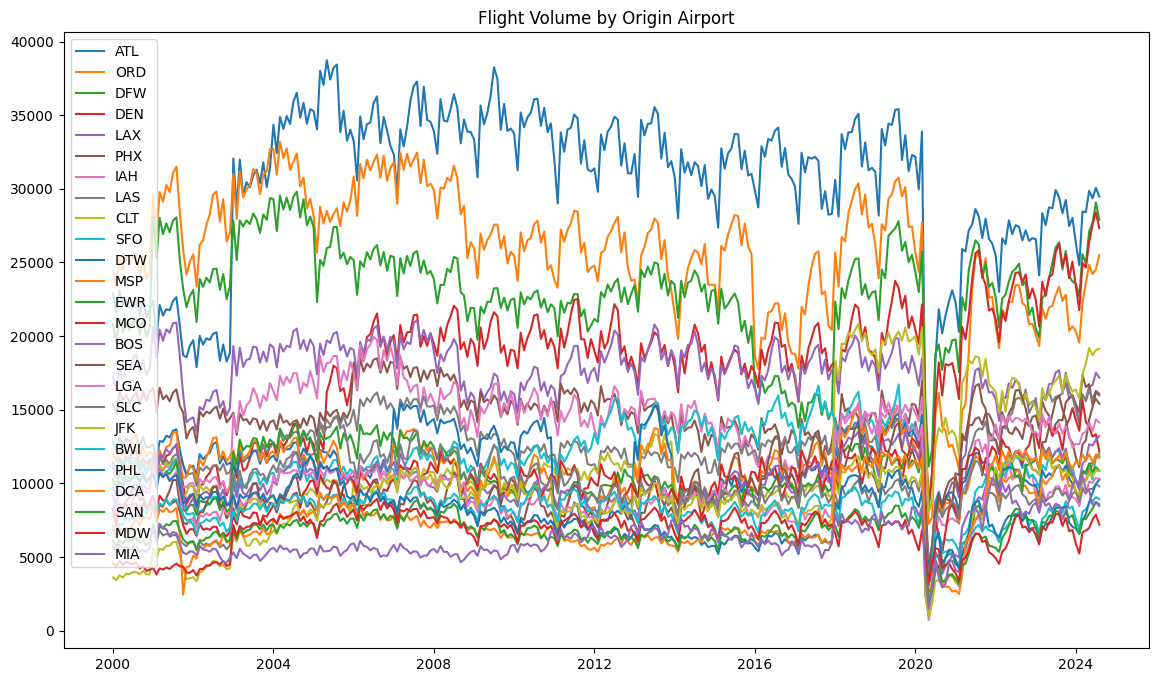

In [6]:
result = client.execute("SELECT Origin, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, count(*) as count FROM on_time_performance GROUP BY when, Origin ORDER BY when");

plt.figure(figsize=(14, 8))

for code, _ in popular_airports[:25]:
    y = [i[1] for i in result if i[0] == code]
    x = [i[2] for i in result if i[0] == code]
    plt.plot(y, x, label=code)

plt.legend(loc="upper left")
plt.title("Flight Volume by Origin Airport")
plt.show()

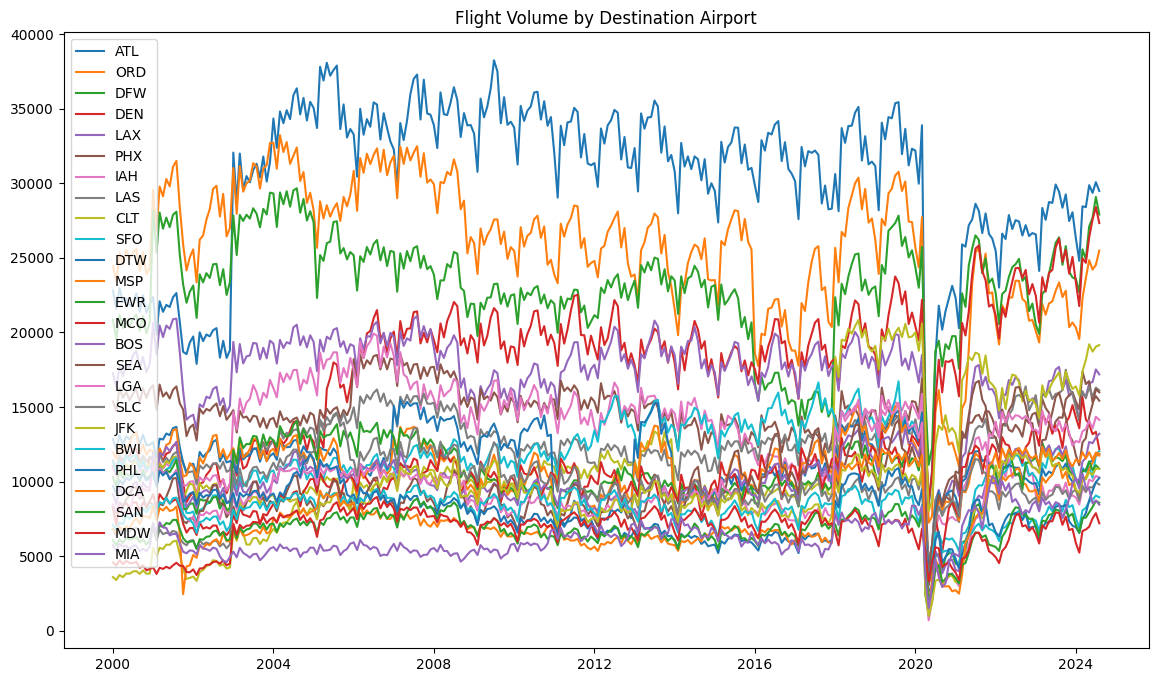

In [7]:
result = client.execute("SELECT Dest, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, count(*) as count FROM on_time_performance GROUP BY when, Dest ORDER BY when");

plt.figure(figsize=(14, 8))

for code, _ in popular_airports[:25]:
    y = [i[1] for i in result if i[0] == code]
    x = [i[2] for i in result if i[0] == code]
    plt.plot(y, x, label=code)

plt.legend(loc="upper left")
plt.title("Flight Volume by Destination Airport")

plt.show()

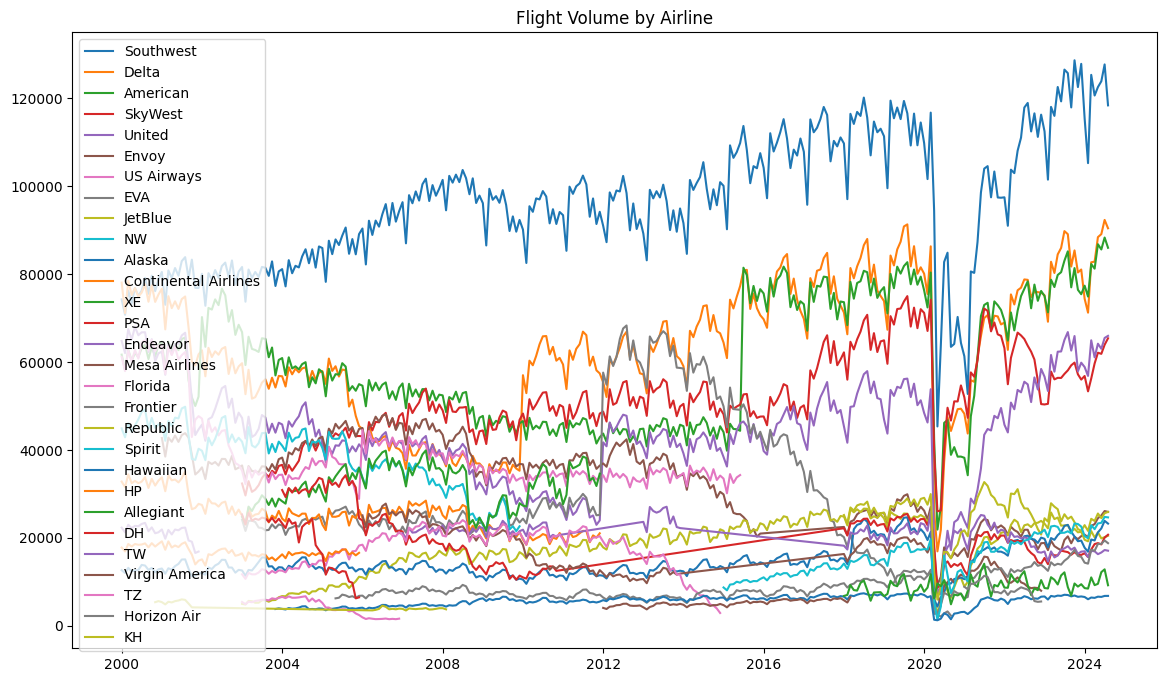

In [8]:
result = client.execute("SELECT Reporting_Airline, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, count(*) as count FROM on_time_performance GROUP BY when, Reporting_Airline ORDER BY when");

plt.figure(figsize=(14, 8))

for code, name in TOP_AIRLINES:
    y = [i[1] for i in result if i[0] == code]
    x = [i[2] for i in result if i[0] == code]
    plt.plot(y, x, label=name)

plt.legend(loc="upper left")
plt.title("Flight Volume by Airline")
plt.show()

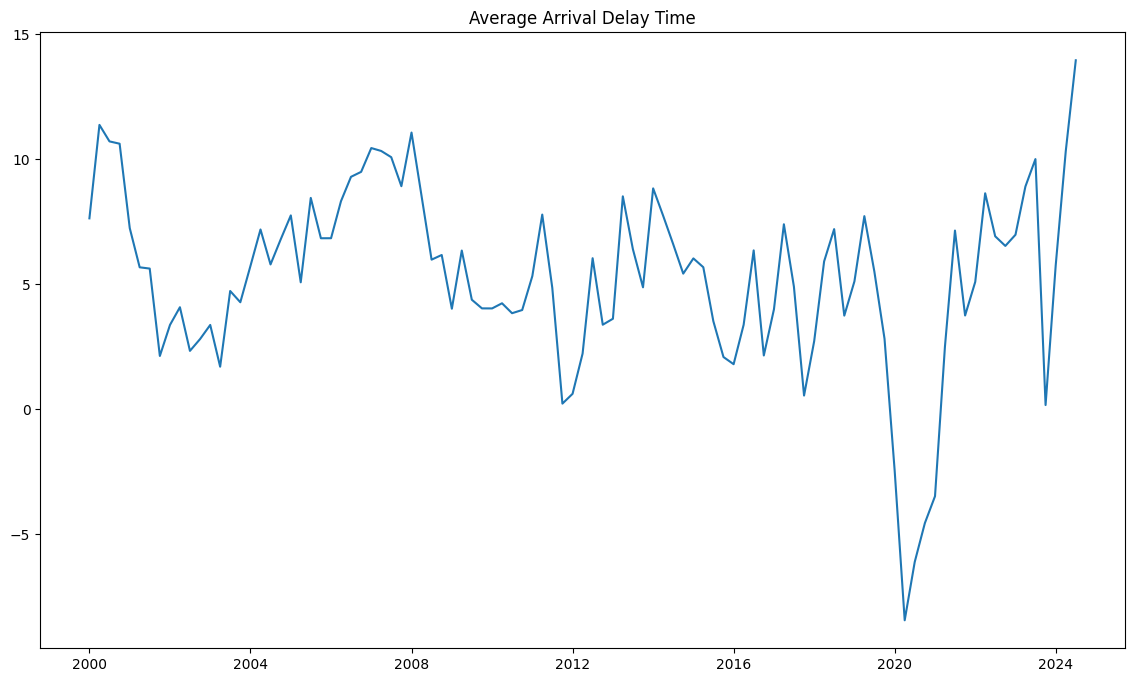

In [9]:
result = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 3 MONTH) as when, avg(ArrDelay) as delay FROM on_time_performance GROUP BY when ORDER BY when");

plt.figure(figsize=(14, 8))
plt.plot(take(result, 0), take(result, 1))
plt.title("Average Arrival Delay Time")
plt.show()

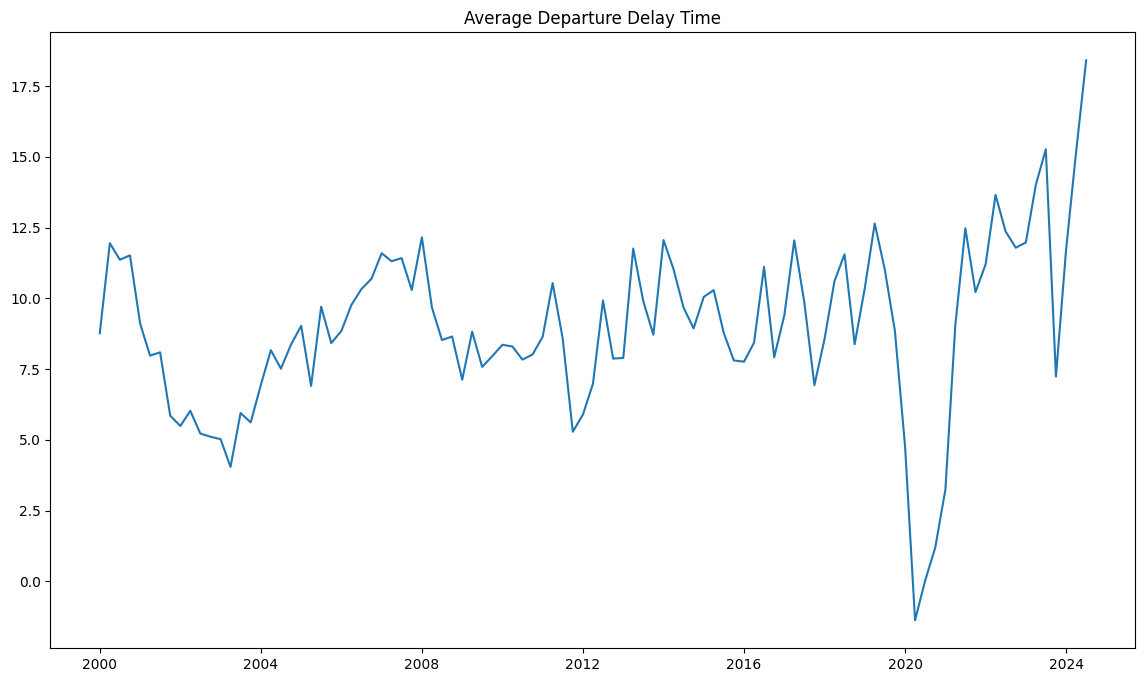

In [10]:
result = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 3 MONTH) as when, avg(DepDelay) as delay FROM on_time_performance GROUP BY when ORDER BY when");

plt.figure(figsize=(14, 8))
plt.plot(take(result, 0), take(result, 1))
plt.title("Average Departure Delay Time")
plt.show()

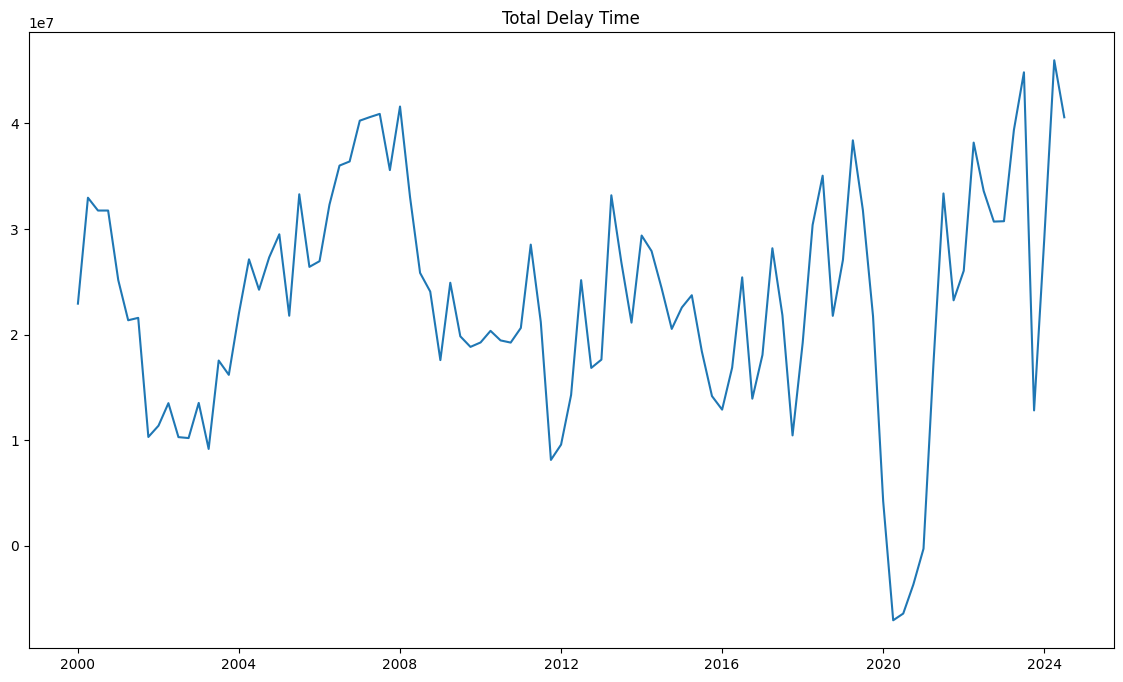

In [11]:
result = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 3 MONTH) as when, sum(DepDelay)+sum(ArrDelay) as delay FROM on_time_performance GROUP BY when ORDER BY when");

plt.figure(figsize=(14, 8))
plt.plot(take(result, 0), take(result, 1))
plt.title("Total Delay Time")
plt.show()

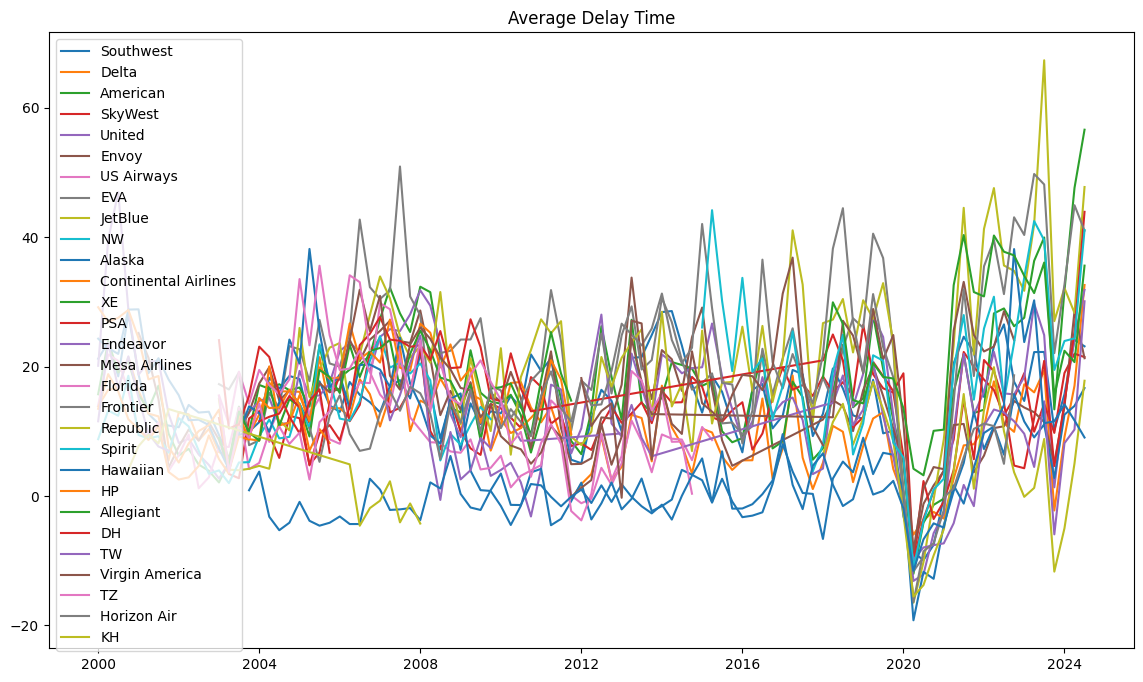

In [12]:
result = client.execute("SELECT Reporting_Airline, toStartOfInterval(FlightDate, INTERVAL 3 MONTH) as when, avg(ArrDelay)+avg(DepDelay) as delay FROM on_time_performance GROUP BY when, Reporting_Airline ORDER BY when");

plt.figure(figsize=(14, 8))

for code, name in TOP_AIRLINES:
    y = [i[1] for i in result if i[0] == code]
    x = [i[2] for i in result if i[0] == code]
    plt.plot(y, x, label=name)

plt.title("Average Delay Time")
plt.legend(loc="upper left")
plt.show()

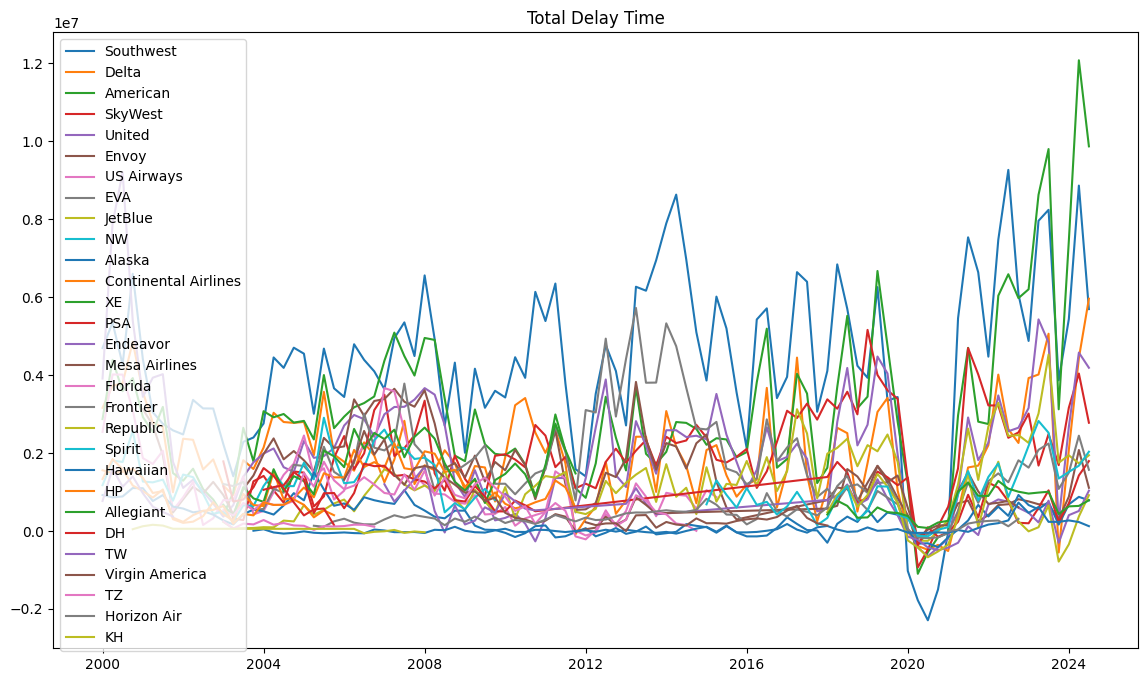

In [13]:

result = client.execute("SELECT Reporting_Airline, toStartOfInterval(FlightDate, INTERVAL 3 MONTH) as when, sum(ArrDelay)+sum(DepDelay) as delay FROM on_time_performance GROUP BY when, Reporting_Airline ORDER BY when");

plt.figure(figsize=(14, 8))

v = 0
for code, name in TOP_AIRLINES:
    y = [i[1] for i in result if i[0] == code]
    x = [i[2] for i in result if i[0] == code]
    plt.plot(y, x, label=name)

plt.title("Total Delay Time")
plt.legend(loc="upper left")
plt.show()

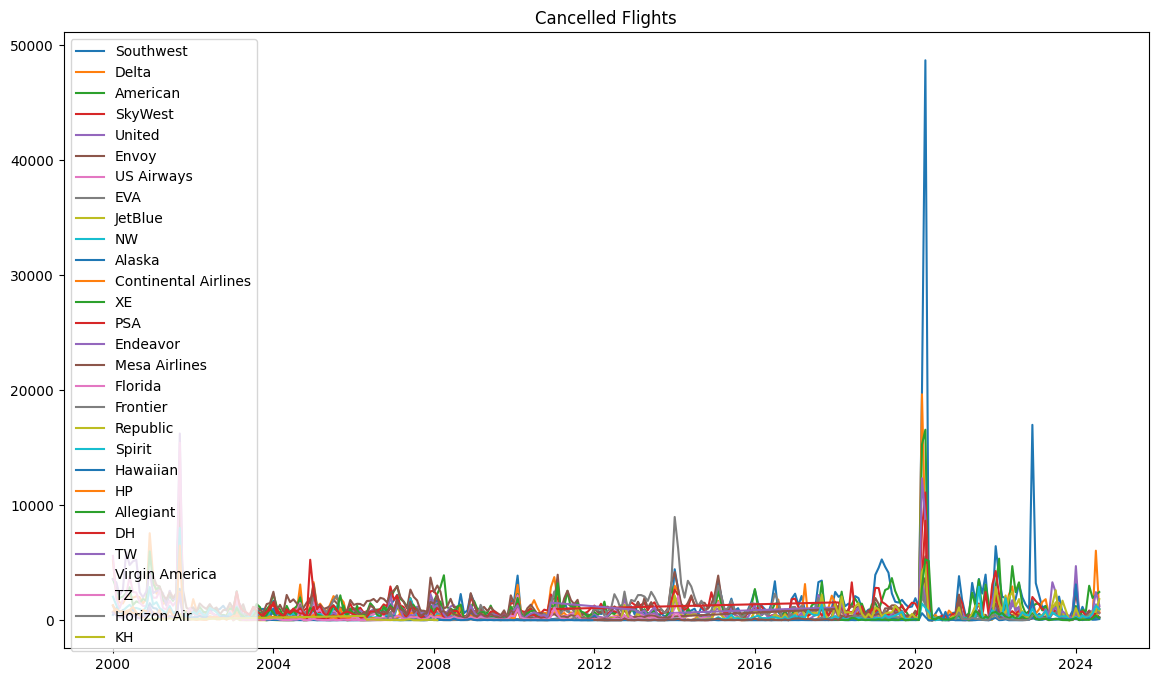

In [14]:
result = client.execute("SELECT Reporting_Airline, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, count(*) as count FROM on_time_performance WHERE Cancelled=1 GROUP BY when, Reporting_Airline ORDER BY when");

plt.figure(figsize=(14, 8))

v = 0
for code, name in TOP_AIRLINES:
    y = [i[1] for i in result if i[0] == code]
    x = [i[2] for i in result if i[0] == code]
    plt.plot(y, x, label=name)

plt.title("Cancelled Flights")
plt.legend(loc="upper left")
plt.show()

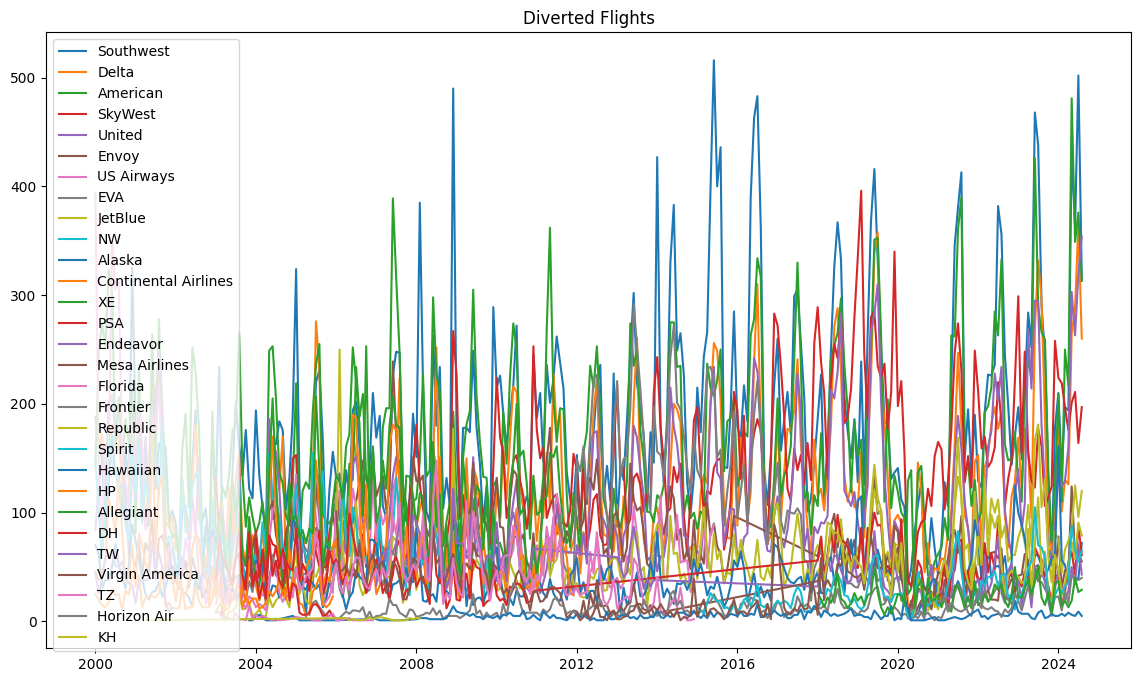

In [15]:
result = client.execute("SELECT Reporting_Airline, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, count(*) as count FROM on_time_performance WHERE Diverted=1 GROUP BY when, Reporting_Airline ORDER BY when");

plt.figure(figsize=(14, 8))

v = 0
for code, name in TOP_AIRLINES:
    y = [i[1] for i in result if i[0] == code]
    x = [i[2] for i in result if i[0] == code]
    plt.plot(y, x, label=name)

plt.title("Diverted Flights")
plt.legend(loc="upper left")
plt.show()

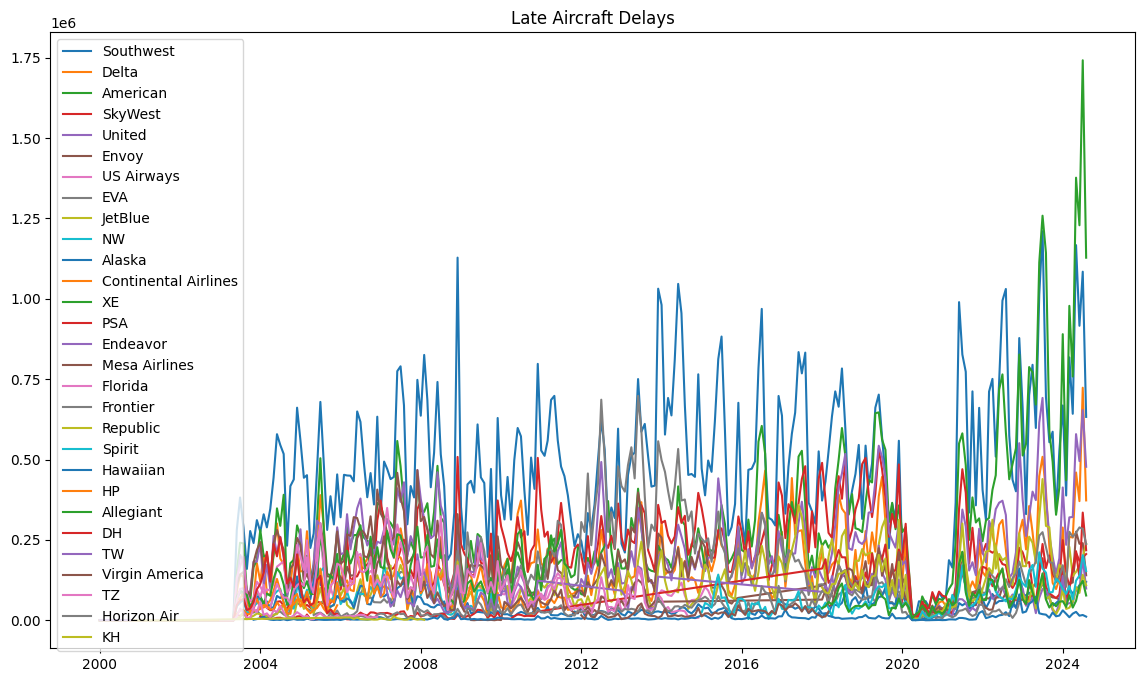

In [16]:
result = client.execute("SELECT Reporting_Airline, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, sum(LateAircraftDelay) as delay FROM on_time_performance GROUP BY when, Reporting_Airline ORDER BY when");

plt.figure(figsize=(14, 8))

v = 0
for code, name in TOP_AIRLINES:
    y = [i[1] for i in result if i[0] == code]
    x = [i[2] for i in result if i[0] == code]
    plt.plot(y, x, label=name)

plt.title("Late Aircraft Delays")
plt.legend(loc="upper left")
plt.show()

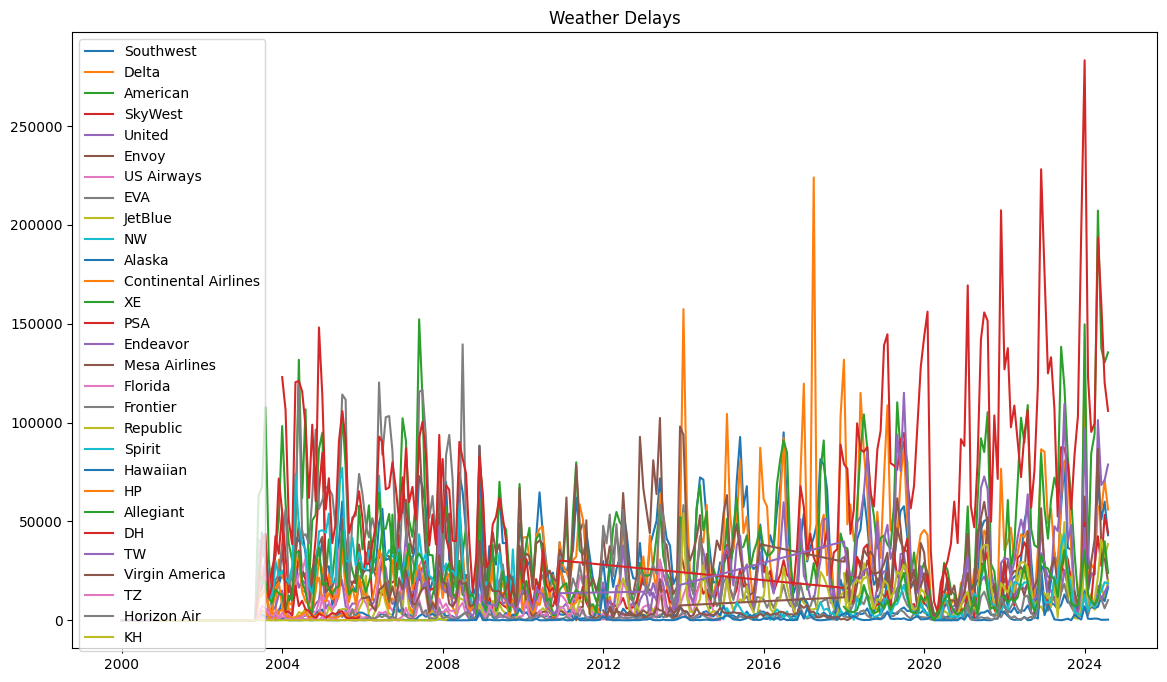

In [17]:
result = client.execute("SELECT Reporting_Airline, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, sum(WeatherDelay) as delay FROM on_time_performance GROUP BY when, Reporting_Airline ORDER BY when");

plt.figure(figsize=(14, 8))

v = 0
for code, name in TOP_AIRLINES:
    y = [i[1] for i in result if i[0] == code]
    x = [i[2] for i in result if i[0] == code]
    plt.plot(y, x, label=name)

plt.title("Weather Delays")
plt.legend(loc="upper left")
plt.show()

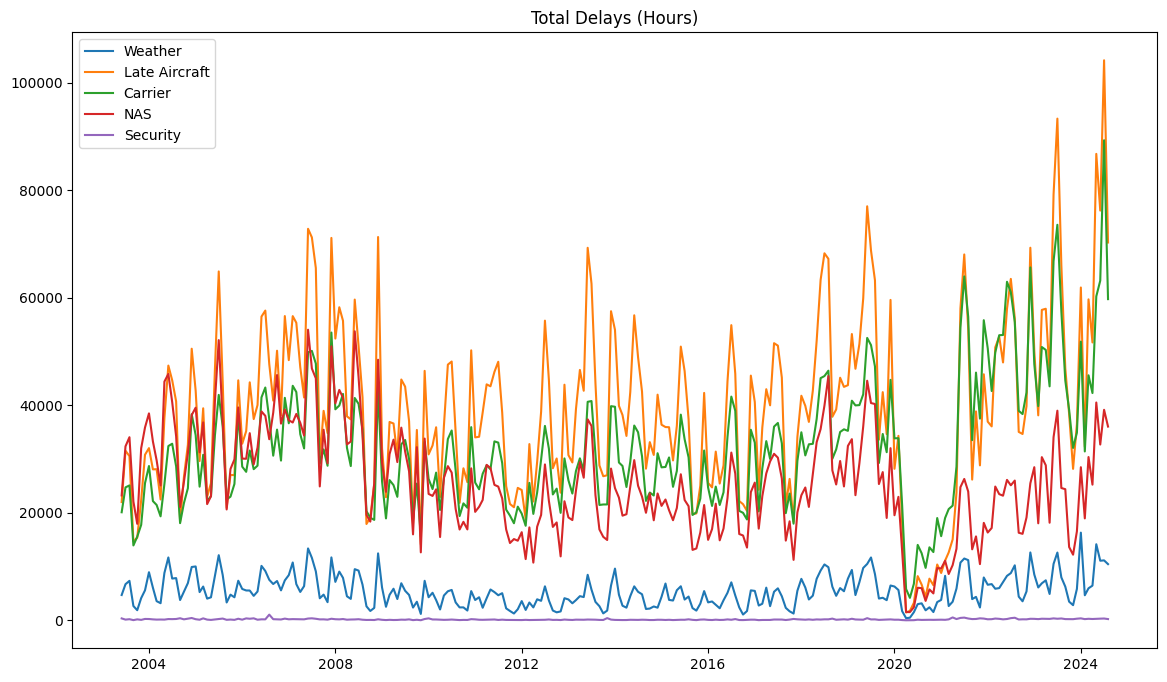

In [18]:
weather = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, sum(WeatherDelay) / 60 as delay FROM on_time_performance WHERE WeatherDelay > 0 GROUP BY when ORDER BY when");
late_aircraft = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, sum(LateAircraftDelay) / 60 as delay FROM on_time_performance WHERE LateAircraftDelay > 0 GROUP BY when ORDER BY when");
carrier = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, sum(CarrierDelay) / 60 as delay FROM on_time_performance WHERE CarrierDelay > 0 GROUP BY when ORDER BY when");
nas = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, sum(NASDelay) / 60 as delay FROM on_time_performance WHERE NASDelay > 0 GROUP BY when ORDER BY when");
security = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, sum(SecurityDelay) / 60 as delay FROM on_time_performance WHERE SecurityDelay > 0 GROUP BY when ORDER BY when");

plt.figure(figsize=(14, 8))

plt.plot(take(weather, 0), take(weather, 1), label="Weather")
plt.plot(take(late_aircraft, 0), take(late_aircraft, 1), label="Late Aircraft")
plt.plot(take(carrier, 0), take(carrier, 1), label="Carrier")
plt.plot(take(nas, 0), take(nas, 1), label="NAS")
plt.plot(take(security, 0), take(security, 1), label="Security")

plt.title("Total Delays (Hours)")
plt.legend(loc="upper left")
plt.show()

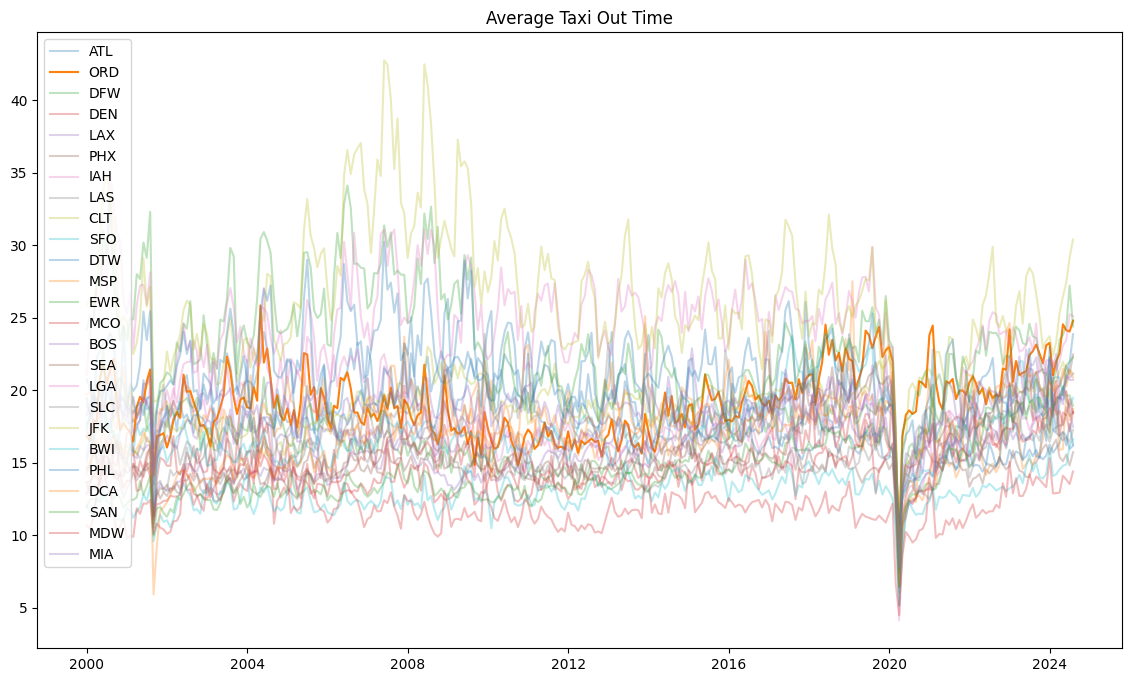

In [19]:
popular_airports = client.execute("SELECT Origin, count(*) as count FROM on_time_performance GROUP BY Origin ORDER BY count DESC");

taxiout = client.execute("SELECT Origin, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, avg(TaxiOut) as delay FROM on_time_performance GROUP BY when, Origin ORDER BY when");

plt.figure(figsize=(14, 8))

for code, _ in popular_airports[:25]:
    dataset = [i for i in taxiout if i[0] == code]
    plt.plot(take(dataset, 1), take(dataset, 2), label=code, alpha=0.3 if code != 'ORD' else 1.0)

plt.title("Average Taxi Out Time")
plt.legend(loc="upper left")
plt.show()

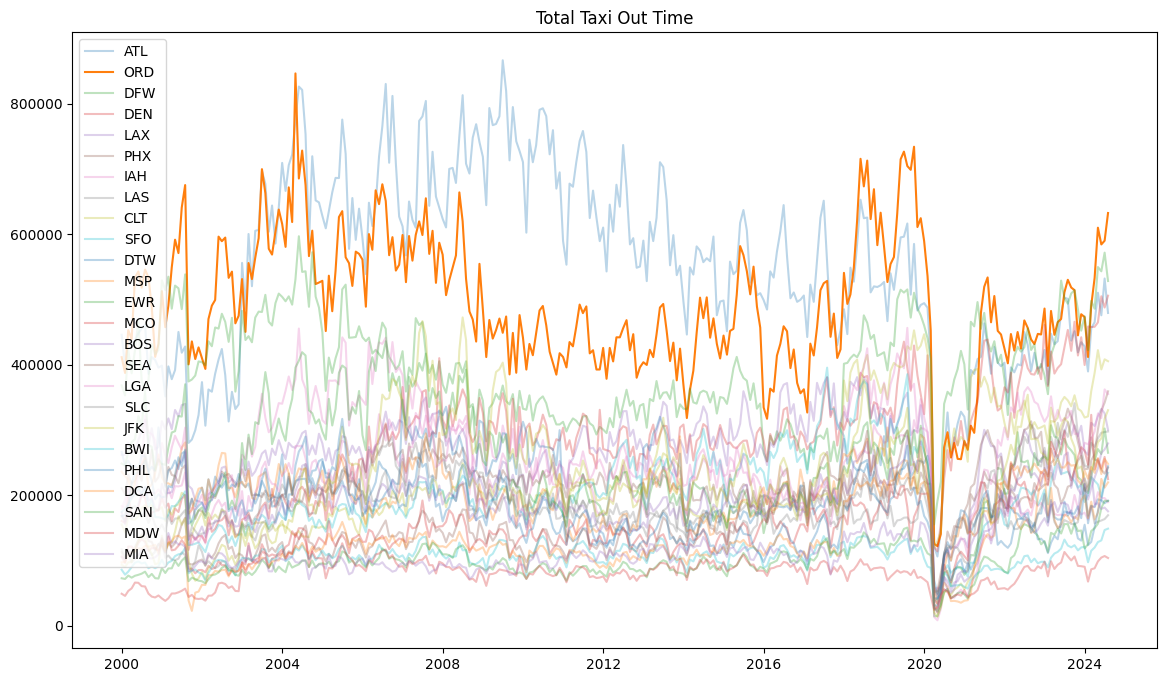

In [20]:
popular_airports = client.execute("SELECT Origin, count(*) as count FROM on_time_performance GROUP BY Origin ORDER BY count DESC");

taxiout = client.execute("SELECT Origin, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, sum(TaxiOut) as delay FROM on_time_performance GROUP BY when, Origin ORDER BY when");

plt.figure(figsize=(14, 8))

for code, _ in popular_airports[:25]:
    dataset = [i for i in taxiout if i[0] == code]
    plt.plot(take(dataset, 1), take(dataset, 2), label=code, alpha=0.3 if code != 'ORD' else 1.0)

plt.title("Total Taxi Out Time")
plt.legend(loc="upper left")
plt.show()

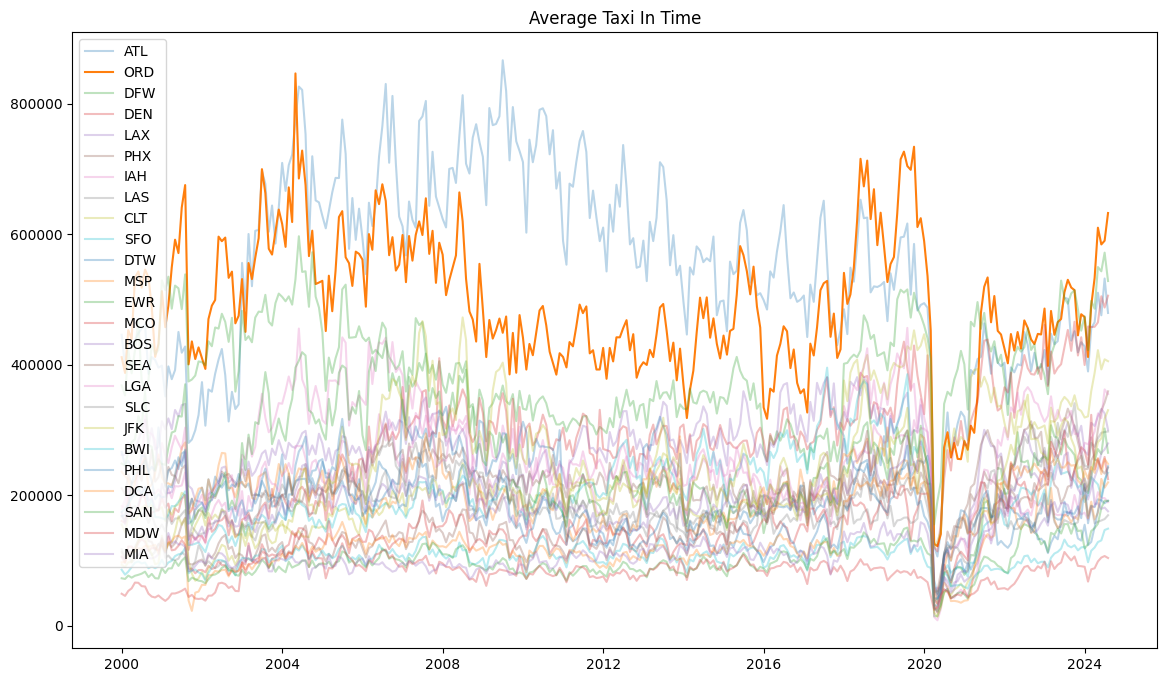

In [21]:
popular_airports = client.execute("SELECT Origin, count(*) as count FROM on_time_performance GROUP BY Origin ORDER BY count DESC");

taxin = client.execute("SELECT Dest, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, avg(TaxiIn) as delay FROM on_time_performance GROUP BY when, Dest ORDER BY when");

plt.figure(figsize=(14, 8))

for code, _ in popular_airports[:25]:
    dataset = [i for i in taxiout if i[0] == code]
    plt.plot(take(dataset, 1), take(dataset, 2), label=code, alpha=0.3 if code != 'ORD' else 1.0)

plt.title("Average Taxi In Time")
plt.legend(loc="upper left")
plt.show()

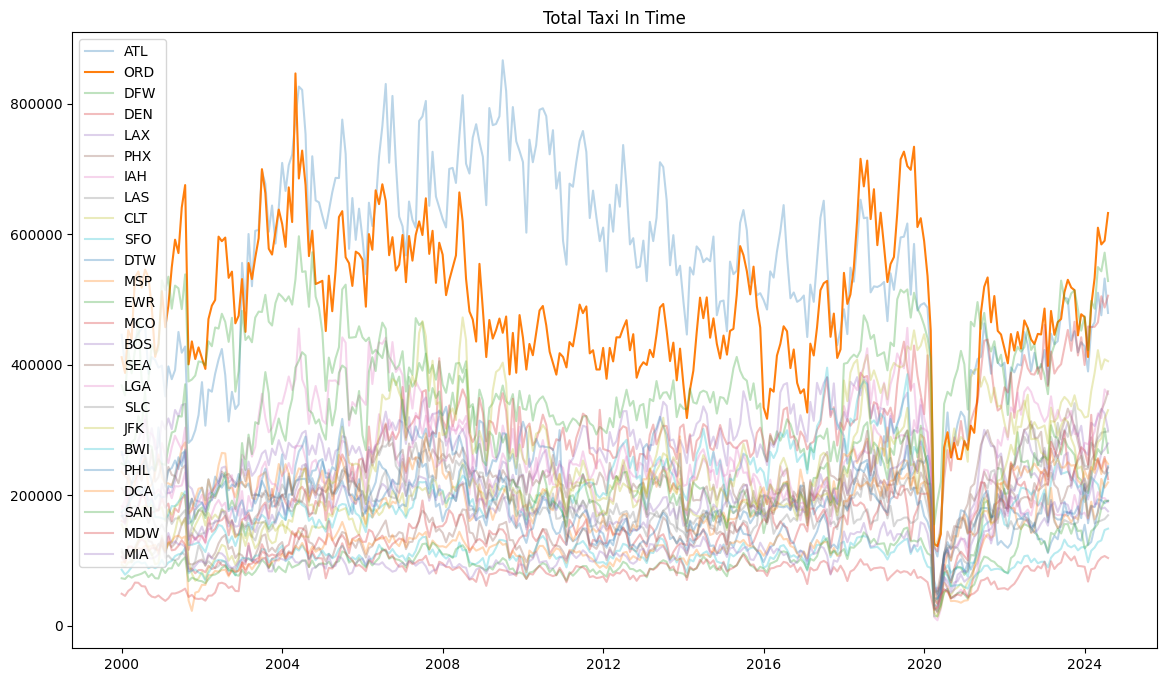

In [22]:
popular_airports = client.execute("SELECT Origin, count(*) as count FROM on_time_performance GROUP BY Origin ORDER BY count DESC");

taxin = client.execute("SELECT Dest, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, sum(TaxiIn) as delay FROM on_time_performance GROUP BY when, Dest ORDER BY when");

plt.figure(figsize=(14, 8))

for code, _ in popular_airports[:25]:
    dataset = [i for i in taxiout if i[0] == code]
    plt.plot(take(dataset, 1), take(dataset, 2), label=code, alpha=0.3 if code != 'ORD' else 1.0)

plt.title("Total Taxi In Time")
plt.legend(loc="upper left")
plt.show()

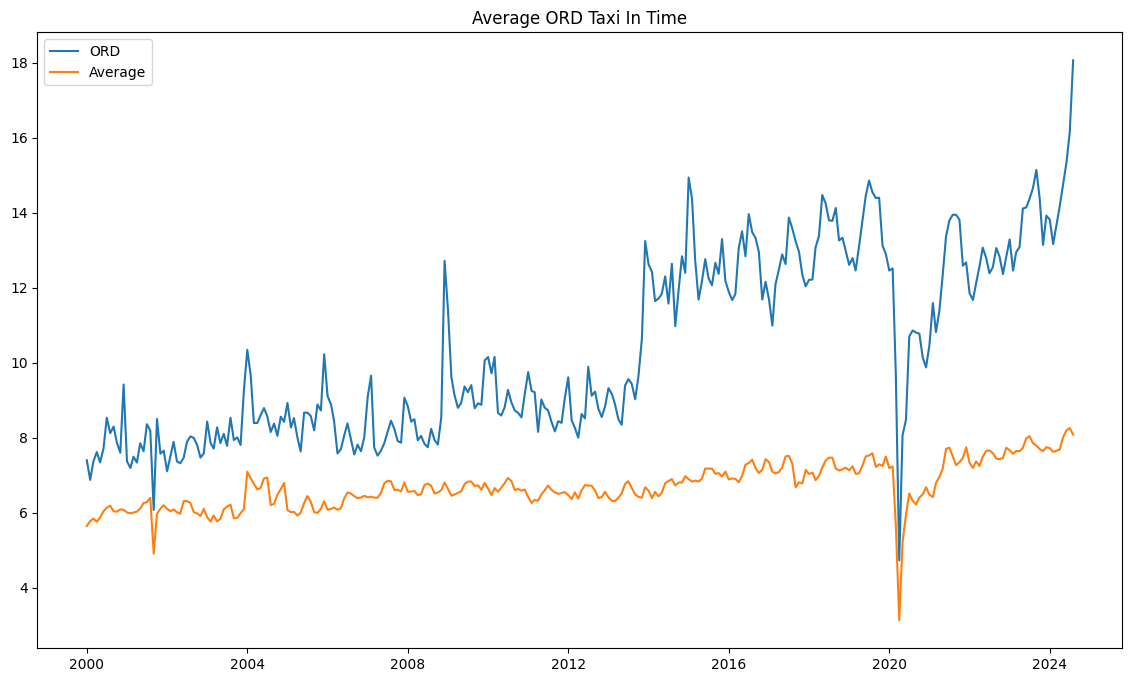

In [23]:
ord_ = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, avg(TaxiIn) as delay FROM on_time_performance WHERE Dest='ORD' GROUP BY when ORDER BY when");
average = client.execute("SELECT toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, avg(TaxiIn) as delay FROM on_time_performance WHERE Dest != 'ORD' GROUP BY when ORDER BY when");


plt.figure(figsize=(14, 8))
plt.plot(take(ord_, 0), take(ord_, 1), label="ORD")
plt.plot(take(average, 0), take(average, 1), label="Average")


plt.title("Average ORD Taxi In Time")
plt.legend(loc="upper left")
plt.show()

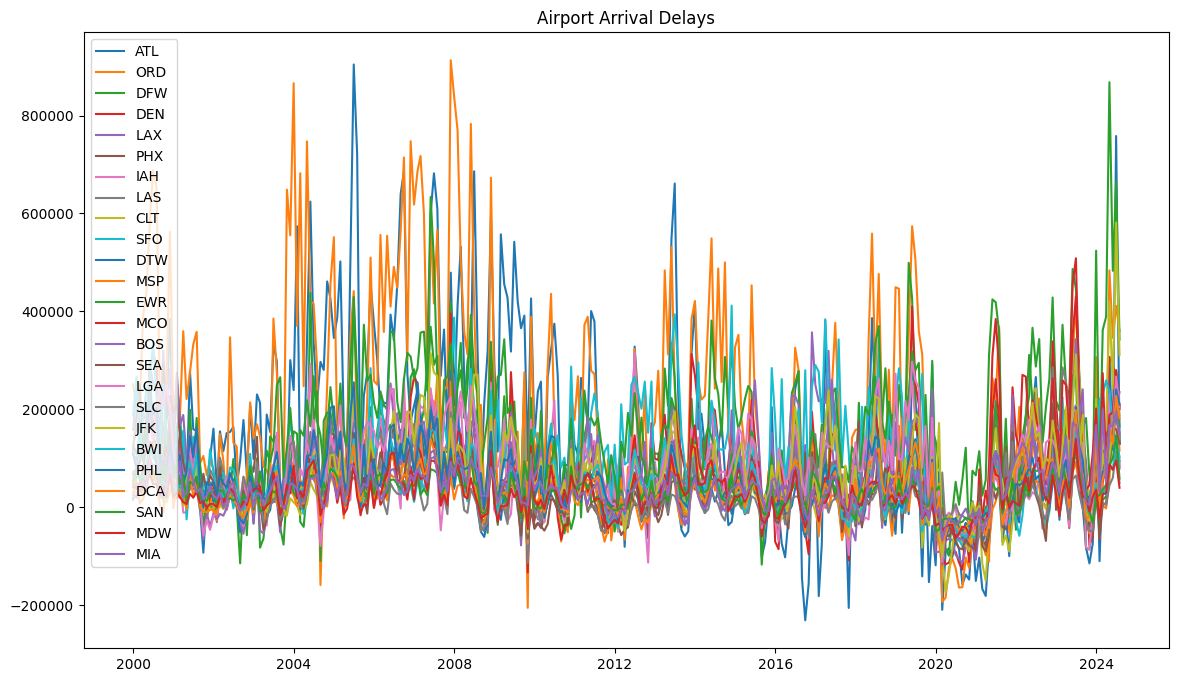

In [24]:
arrdelay = client.execute("SELECT Dest, toStartOfInterval(FlightDate, INTERVAL 1 MONTH) as when, sum(ArrDelay) as delay FROM on_time_performance GROUP BY when, Dest ORDER BY when");

plt.figure(figsize=(14, 8))

for code, _ in popular_airports[:25]:
    dataset = [i for i in arrdelay if i[0] == code]
    plt.plot(take(dataset, 1), take(dataset, 2), label=code)

plt.title("Airport Arrival Delays")
plt.legend(loc="upper left")
plt.show()